# Objective
-----------
Build a regression model to predict trip duration based on:
- Time of day
- Weather
- User type
- Bike type
- Zip code demographics

Finally, compare performance across cities

# Libraries

In [1]:
from SourceCode.Analysis.predictive_analysis import prepare_data_for_model, rectify_column_types

In [2]:
import plotly_express as px
import xgboost as xgb
import pandas as pd
import numpy as np
import random
import glob
import os

# Load data

In [3]:
# Choose the years to train and test
year_to_train = 2023
year_to_test = 2024

In [4]:
# Create paths and load the data
curated_data_folder = "./CuratedData"
bikes_path = f"{curated_data_folder}/bikes.csv"
demographics_path = f"{curated_data_folder}/demographics.csv"
weather_path = f"{curated_data_folder}/weather.csv"

df_bikes = pd.read_csv(bikes_path)
df_demographics = pd.read_csv(demographics_path)
df_weather = pd.read_csv(weather_path, parse_dates=True)
df_weather["date"] = pd.to_datetime(df_weather["date"])

# Creating a list of files corresponding to the year to load them
pattern = f"{curated_data_folder}/features_{year_to_train}*.csv"
trips_feat_list_train = sorted(glob.glob(pattern))

pattern = f"{curated_data_folder}/features_{year_to_test}*.csv"
trips_feat_list_test = sorted(glob.glob(pattern))

# Predictive Model

## Train Model

In [5]:
# Define parameters for deterministic training
params = {
    'objective': 'reg:squarederror', 
    'tree_method': 'hist',
    'seed': 42,                        # Main random seed
    
    # Crucial for enable_categorical=True:
    'max_cat_to_onehot': 1,            # Force consistent handling of high-cardinality categories

    # To ensure consistency across different parallel executions (if applicable):
    'nthread': 1,                      # Use a single thread
    'num_parallel_tree': 1             # Use 1 for boosting, might be different for RF
}

df_X_train = pd.DataFrame()
df_Y_train = pd.DataFrame()

# Prepare data for model
for file in trips_feat_list_train:
    print(f"Preparing file: {os.path.basename(file)}")
    # To review used variables, please check the file predictive_analysis.py
    df_X_month, df_Y_month = prepare_data_for_model(file, df_bikes, df_demographics, df_weather)

    df_X_train = pd.concat([df_X_train, df_X_month])
    df_Y_train = pd.concat([df_Y_train, df_Y_month])

df_X_train = rectify_column_types(df_X_train)

# Start XGBoost training
print("Training XGBoost model")
dtrain_batch = xgb.DMatrix(df_X_train, label=df_Y_train, enable_categorical=True)

bst = xgb.train(params, dtrain_batch, num_boost_round=50) 

Preparing file: features_2023_01.csv
Preparing file: features_2023_02.csv
Preparing file: features_2023_03.csv
Preparing file: features_2023_04.csv
Preparing file: features_2023_05.csv
Preparing file: features_2023_06.csv
Preparing file: features_2023_07.csv
Preparing file: features_2023_08.csv
Preparing file: features_2023_09.csv
Preparing file: features_2023_10.csv
Preparing file: features_2023_11.csv
Preparing file: features_2023_12.csv
Training XGBoost model


# Test Model

In [23]:
df_X_test = pd.DataFrame()
df_Y_test = pd.DataFrame()

# Prepare data for model
for file in trips_feat_list_test:
    print(f"Preparing file: {os.path.basename(file)}")
    df_X_month, df_Y_month = prepare_data_for_model(file, df_bikes, df_demographics, df_weather)

    df_X_test = pd.concat([df_X_test, df_X_month])
    df_Y_test = pd.concat([df_Y_test, df_Y_month])

df_X_test = rectify_column_types(df_X_test)

# Start XGBoost prediction
print("Predicting with XGBoost model")
dtest_batch = xgb.DMatrix(df_X_test, label=df_Y_test, enable_categorical=True)
prediction = bst.predict(dtest_batch)

Preparing file: features_2024_01.csv
Preparing file: features_2024_02.csv
Preparing file: features_2024_03.csv
Preparing file: features_2024_04.csv
Preparing file: features_2024_05.csv
Preparing file: features_2024_06.csv
Preparing file: features_2024_07.csv
Preparing file: features_2024_08.csv
Preparing file: features_2024_09.csv
Preparing file: features_2024_10.csv
Preparing file: features_2024_11.csv
Preparing file: features_2024_12.csv
Predicting with XGBoost model


## Results

### Overall

In [10]:
# create dataframe to store all the results
df_results = pd.DataFrame()
df_results["city"] = df_X_test["city_start"]
df_results["month"] = df_X_test["month"]
df_results["hour_of_day"] = df_X_test["hour_of_day"]
df_results["actual"] = df_Y_test["duration"]
df_results["predicted"] = prediction
df_results["error"] = df_results["actual"] - df_results["predicted"]
df_results["absolute_error"] = df_results["error"].abs()

group_results = df_results.groupby(by=['month', 'hour_of_day'], observed=False)

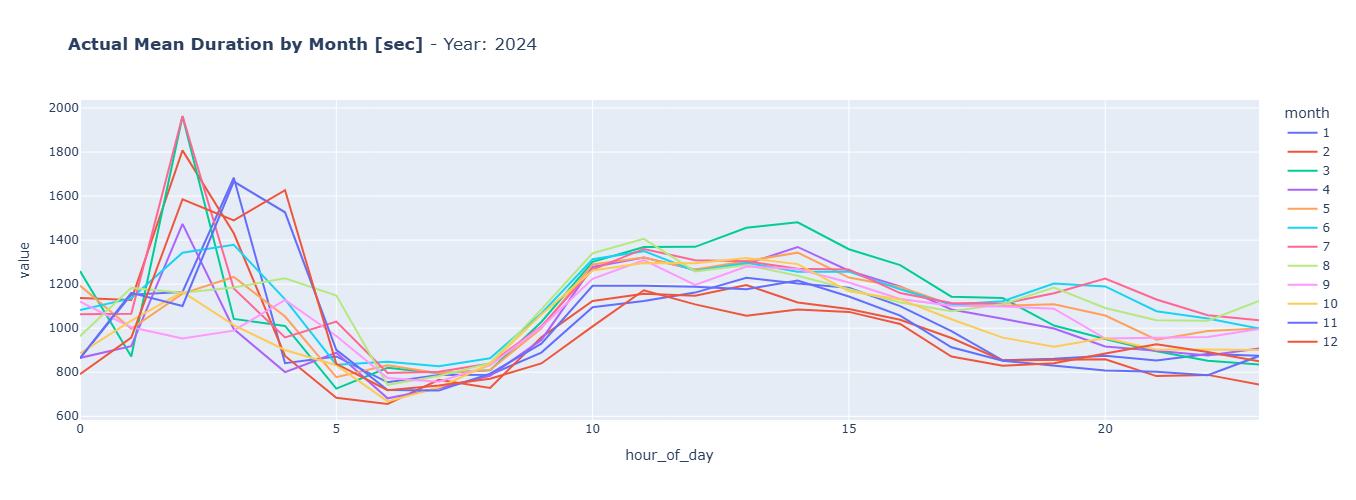

In [300]:
actual_month_means = group_results['actual'].mean().unstack(level='hour_of_day').T
fig = px.line(actual_month_means, title=f"<b>Actual Mean Duration by Month [sec]</b> - Year: {year_to_test}", width=1000, height=500)

fig.show()

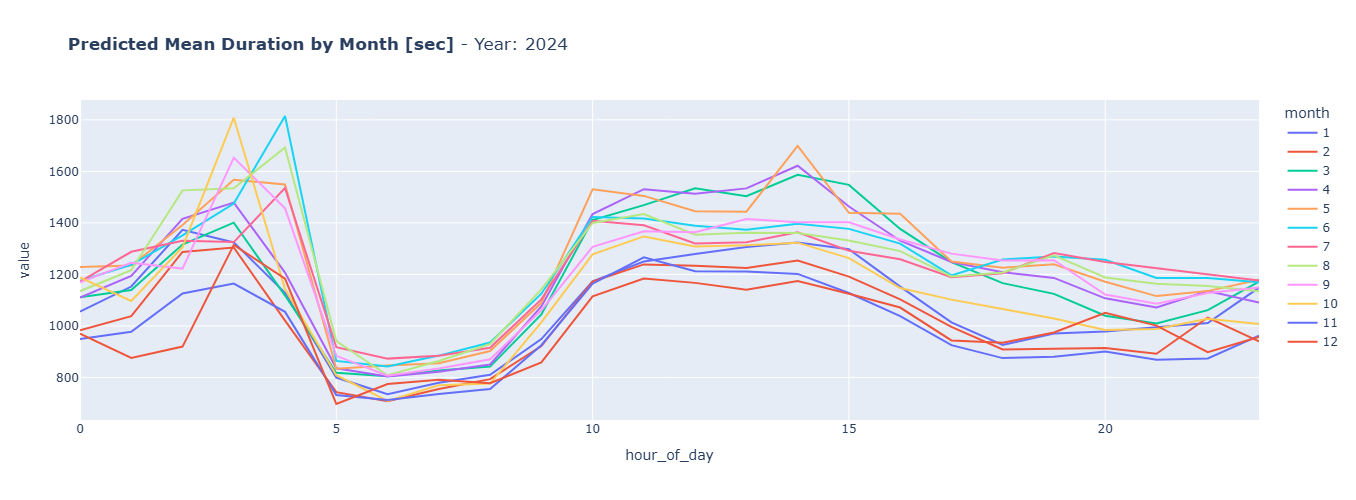

In [307]:
predicted_month_means = group_results['predicted'].mean().unstack(level='hour_of_day').T
fig = px.line(predicted_month_means, title=f"<b>Predicted Mean Duration by Month [sec]</b> - Year: {year_to_test}", width=1000, height=500)

fig.show()

In [11]:
mae_overall = df_results["absolute_error"].mean()

print(f"Mean Absolute Error: {mae_overall} - Overall year {year_to_test}")

Mean Absolute Error: 834.2708524178821 - Overall year 2024


**Notes:** 

This shows that the mean of the duration prediction is similar to the actual duration, even though a different year is used for training. 
Therefore, the trained model achieves similar duration trends.
However, the Mean Absolute Error indicates that the duration prediction is usually inaccurate by around 14 minutes ~ 840 seconds.

### By City

In [13]:
# Divide results by city
df_results_washington = df_results.loc[df_results["city"] == "Washington D.C."]
df_results_los_angeles = df_results.loc[df_results["city"] == "Los Angeles"]

group_results_washington = df_results_washington.groupby(by=['month', 'hour_of_day'], observed=False)
group_results_los_angeles = df_results_los_angeles.groupby(by=['month', 'hour_of_day'], observed=False)

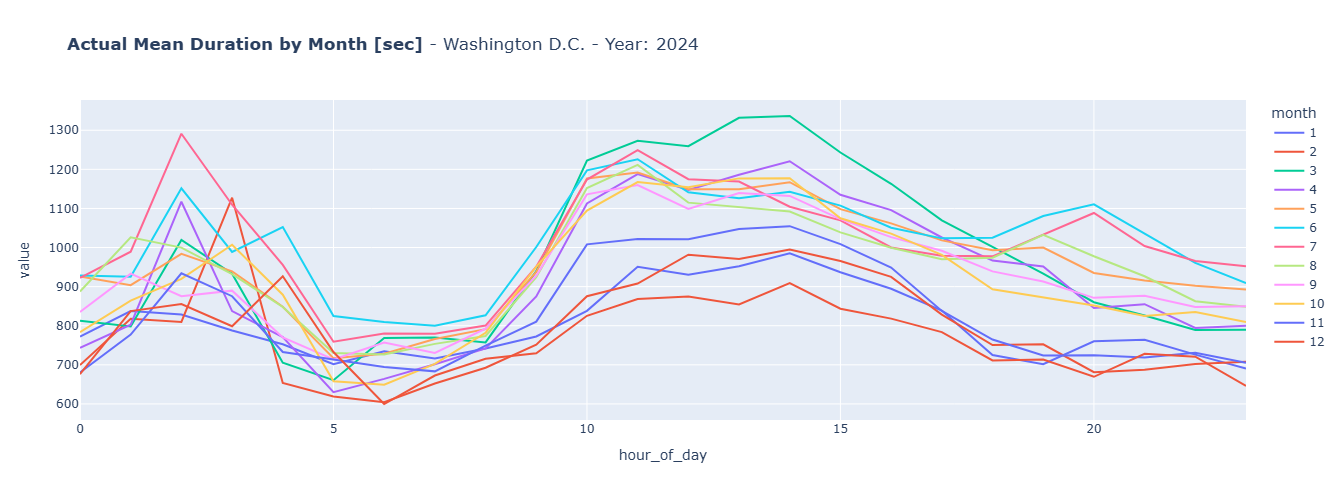

In [309]:
actual_month_means_washington = group_results_washington['actual'].mean().unstack(level='hour_of_day').T
fig = px.line(actual_month_means_washington, title=f"<b>Actual Mean Duration by Month [sec]</b> - Washington D.C. - Year: {year_to_test}", width=1000, height=500)

fig.show()

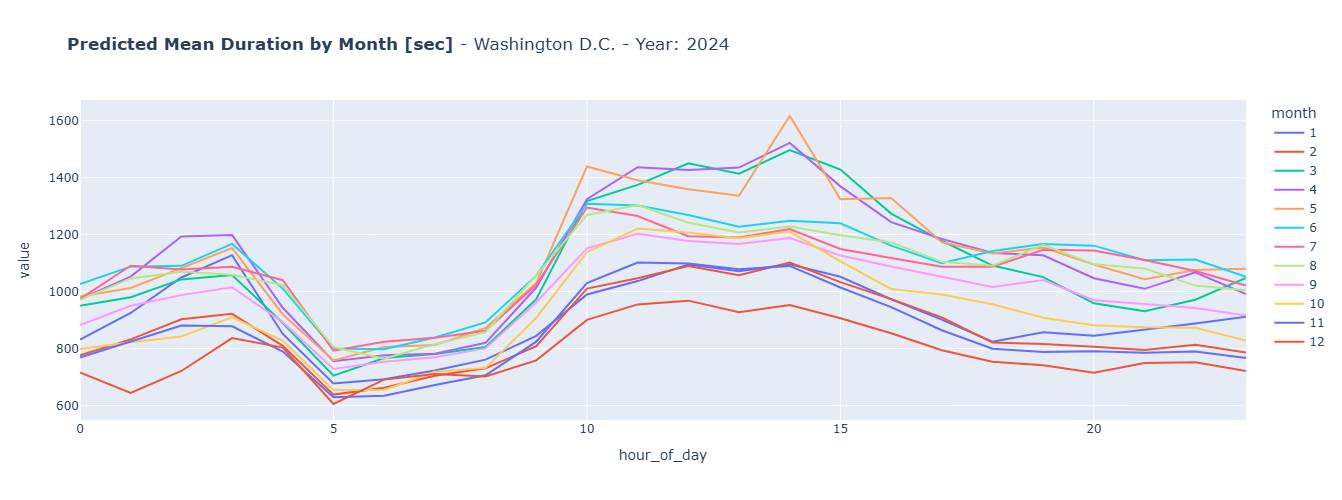

In [308]:
predicted_month_means_washington = group_results_washington['predicted'].mean().unstack(level='hour_of_day').T
fig = px.line(predicted_month_means_washington, title=f"<b>Predicted Mean Duration by Month [sec]</b> - Washington D.C. - Year: {year_to_test}", width=1000, height=500)

fig.show()

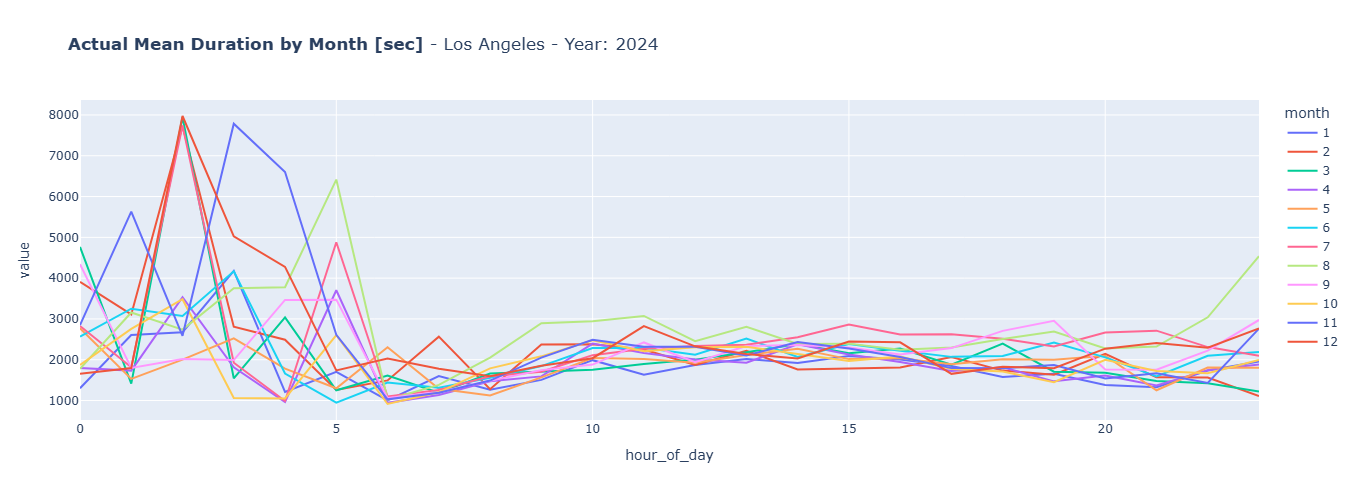

In [310]:
actual_month_means_los_angeles = group_results_los_angeles['actual'].mean().unstack(level='hour_of_day').T
fig = px.line(actual_month_means_los_angeles, title=f"<b>Actual Mean Duration by Month [sec]</b> - Los Angeles - Year: {year_to_test}", width=1000, height=500)

fig.show()

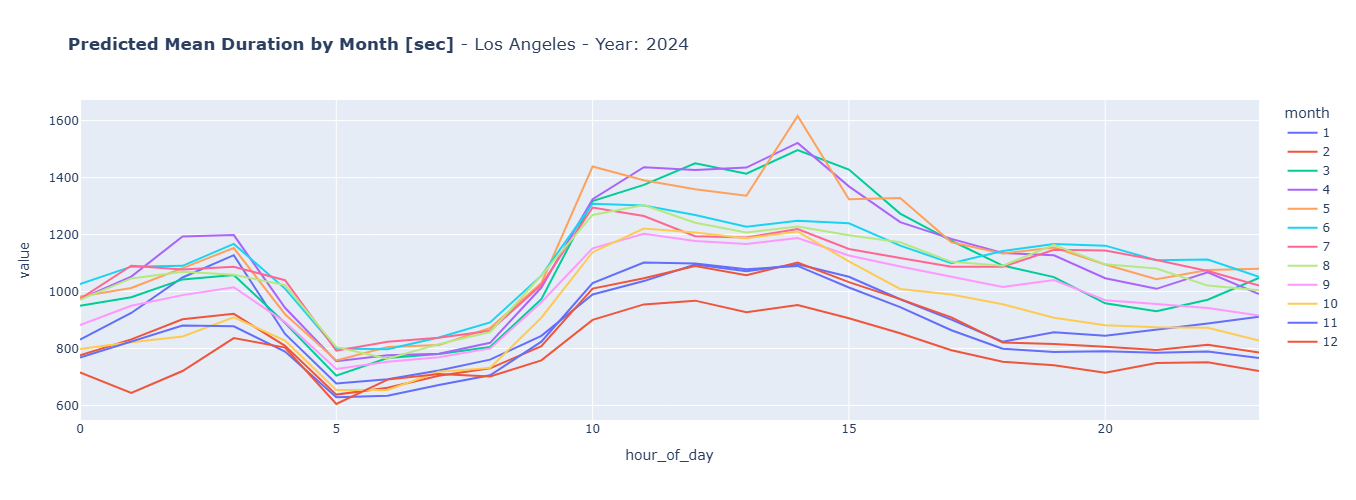

In [312]:
predicted_month_means_los_angeles = group_results_los_angeles['predicted'].mean().unstack(level='hour_of_day').T
fig = px.line(predicted_month_means_washington, title=f"<b>Predicted Mean Duration by Month [sec]</b> - Los Angeles - Year: {year_to_test}", width=1000, height=500)

fig.show()

In [14]:
mae_washington = df_results_washington["absolute_error"].mean()
mae_los_angeles = df_results_los_angeles["absolute_error"].mean()

print(f"Mean Absolute Error: {mae_washington:03f} - Washington D.C.")
print(f"Mean Absolute Error: {mae_los_angeles:03f} - Los Angeles")

Mean Absolute Error: 686.358681 - Washington D.C.
Mean Absolute Error: 2102.864115 - Los Angeles


**Notes:**

This shows that Los Angeles exhibits very different behavior during the first hours of the day, increasing the prediction error. 
Additionally, the predictions for Washington, D.C. are better based on the Mean Absolute Error. This could be because the Washington D.C. training data is more than the training data from Los Angeles (data imbalance).

In [24]:
# to strengthen the point that the data is unbalanced, having Los Angeles city as the minority class
df_X_train["city_start"].value_counts()

city_start
Washington D.C.    3863618
Los Angeles         437716
Name: count, dtype: int64

## Feature Importance

In [26]:
# Get model feature importance and sort them
importances = bst.get_score(importance_type='weight')

df_importance = pd.DataFrame(index = importances.keys(), data = importances.values(), columns=["Importance"])
df_importance.index.name = "Features"
df_importance = df_importance.sort_values(by=["Importance"], ascending=False)

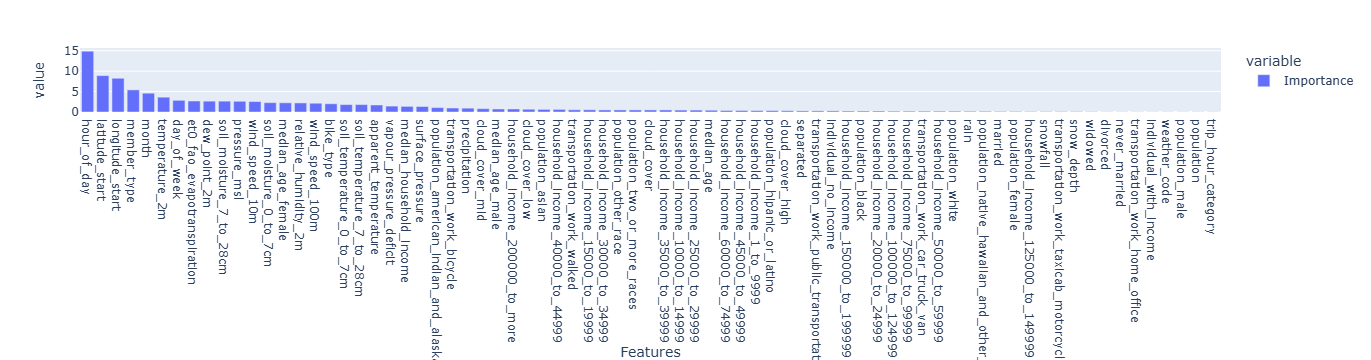

In [27]:
# Plot feature importance from the most relevant on the right, to the least relevant on the left
fig = px.bar(df_importance/df_importance.sum()*100)

fig.show()

**Notes:**

This shows the top 7 features that help to predict the trip duration are:
1. Hour of day
2. Latitude start
3. Longitude start
4. Member type
5. Month
6. Temperature
7. Day of week